<a href="https://colab.research.google.com/github/ShriramGithub7/EVA8-Assignment-4/blob/main/EVA8_Session_4_Step2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target, Results, Analysis

Target:

  - Change the skeleton to add different blocks like Input, Convolution, Transaction and Output block
  - Reduce the size of the model to keep it under 15K
  - Add batch normalization to increase model efficiency
  - Add regularization, dropout, GAP

Results:
  - Parameters: 14.5K
  - Best training Accuracy: 99.24%
  - Best Test Accuracy: 99.10%%

Analysis:
  - Model is made light-weight with parameters under 15k
  - Model is overfitting
  - Model is far from its expected accuracy of 99.40% as it achieved max 99.10% accuracy

# Import libraries

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from __future__ import print_function


# Find mean and std deviation of the data

In [2]:
testing_transofrms = transforms.Compose([transforms.ToTensor()])
exp= datasets.MNIST('.data/', train=True, download=True, transform=testing_transofrms)
exp_data = exp.train_data
exp_data=exp.transform(exp_data.numpy())


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/train-labels-idx1-ubyte.gz to .data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .data/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [3]:
print('shape - ', exp_data.shape)
print('size - ', exp_data.size())
print('min - ', exp_data.min())
print('max - ', exp_data.max())
print('mean - ', exp_data.mean())
print('std - ', exp_data.std())
print('var - ', exp_data.var())

shape -  torch.Size([28, 60000, 28])
size -  torch.Size([28, 60000, 28])
min -  tensor(0.)
max -  tensor(1.)
mean -  tensor(0.1307)
std -  tensor(0.3081)
var -  tensor(0.0949)


# Data transformation

In [4]:
#training data transormation

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307), (0.3081))])

#testing data transformation
test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307), (0.3081))])

# Load data, split it in train/test and apply transform 

In [5]:
train = datasets.MNIST('.data/', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('.data/', train=False, download = True, transform=test_transforms)

# Dataloader arguments and Train/Test Dataloaders

In [6]:
from torch.utils.data import dataloader
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA available - ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader=torch.utils.data.DataLoader(train, **dataloader_args)

test_loader=torch.utils.data.DataLoader(test, **dataloader_args)


CUDA available -  True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# View few images

torch.Size([128, 1, 28, 28])
torch.Size([128])


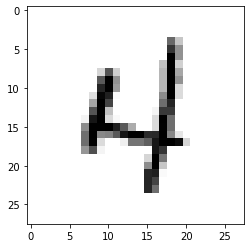

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')


torch.Size([128, 1, 28, 28])
torch.Size([128])


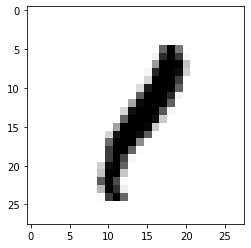

In [8]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
images, labels = next(dataiter)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(),cmap='gray_r')

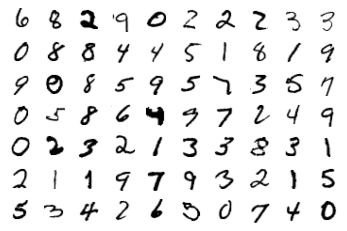

In [9]:
figure = plt.figure()
num_of_images=70
for index in range (1, num_of_images+1):
  plt.subplot(7, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')



# Build the model

In [59]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.container import Sequential
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        #Input block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=0, bias=False), 
            nn.BatchNorm2d(16),
            nn.ReLU()  
        ) #Output - 26*26

        #Convolution Block
        self.convblock2 = nn.Sequential(
            nn.Conv2d(16, 24, 2, padding=0, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU()  
        ) #Output - 24*24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(24, 20, 3, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()  
        ) #Output - 22*22

        #Transaction Block
        self.pool1 = nn.MaxPool2d(2, 2)   #Output - 11*11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(20, 16, 1, padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()  
        ) #Output - 11*11

        #Convolution Block-2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(16, 20, 2, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()  
        ) #Output - 9*9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(20, 20, 3, padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()  
        ) #Output - 7*7

        #Output block
        self.convblock7 = nn.Sequential(
            nn.Conv2d(20, 16, 3, padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()  
        ) #Output - 5*5
        self.convblock8 = nn.Sequential(
            nn.Conv2d(16, 10, 1, padding=0, bias=False),  
        ) #Output - 5*5
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) #Output - 1*1

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [13]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


In [60]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 24, 25, 25]           1,536
       BatchNorm2d-5           [-1, 24, 25, 25]              48
              ReLU-6           [-1, 24, 25, 25]               0
            Conv2d-7           [-1, 20, 23, 23]           4,320
       BatchNorm2d-8           [-1, 20, 23, 23]              40
              ReLU-9           [-1, 20, 23, 23]               0
          Dropout-10           [-1, 20, 23, 23]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 16, 11, 11]             320
      BatchNorm2d-13           [-1, 16, 11, 11]              32
             ReLU-14           [-1, 16,

# Training and Testing

In [95]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)  
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    #test_losses.append(test_loss.item())
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train the model

In [98]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.20355863869190216 Batch_id=468 Accuracy=83.55: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]



Test set: Average loss: 0.2008, Accuracy: 9503/10000 (95.03%)

EPOCH: 1


Loss=0.07916126400232315 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 30.80it/s]



Test set: Average loss: 0.1213, Accuracy: 9662/10000 (96.62%)

EPOCH: 2


Loss=0.06863517314195633 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:14<00:00, 31.48it/s]



Test set: Average loss: 0.0742, Accuracy: 9799/10000 (97.99%)

EPOCH: 3


Loss=0.06891683489084244 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]



Test set: Average loss: 0.0612, Accuracy: 9828/10000 (98.28%)

EPOCH: 4


Loss=0.05130457878112793 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:14<00:00, 31.70it/s]



Test set: Average loss: 0.0483, Accuracy: 9858/10000 (98.58%)

EPOCH: 5


Loss=0.122401662170887 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:14<00:00, 31.31it/s]



Test set: Average loss: 0.0393, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.01574593596160412 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]



Test set: Average loss: 0.0366, Accuracy: 9892/10000 (98.92%)

EPOCH: 7


Loss=0.03254334628582001 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 31.62it/s]



Test set: Average loss: 0.0502, Accuracy: 9845/10000 (98.45%)

EPOCH: 8


Loss=0.0558343380689621 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]



Test set: Average loss: 0.0366, Accuracy: 9885/10000 (98.85%)

EPOCH: 9


Loss=0.04530022665858269 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 29.60it/s]



Test set: Average loss: 0.0377, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.013970855623483658 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]



Test set: Average loss: 0.0335, Accuracy: 9899/10000 (98.99%)

EPOCH: 11


Loss=0.008478204719722271 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]



Test set: Average loss: 0.0330, Accuracy: 9900/10000 (99.00%)

EPOCH: 12


Loss=0.02185850776731968 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]



Test set: Average loss: 0.0330, Accuracy: 9897/10000 (98.97%)

EPOCH: 13


Loss=0.07006283104419708 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.96it/s]



Test set: Average loss: 0.0308, Accuracy: 9908/10000 (99.08%)

EPOCH: 14


Loss=0.029773958027362823 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]



Test set: Average loss: 0.0301, Accuracy: 9910/10000 (99.10%)



# Plot graphs

Text(0.5, 1.0, 'Test Accuracy')

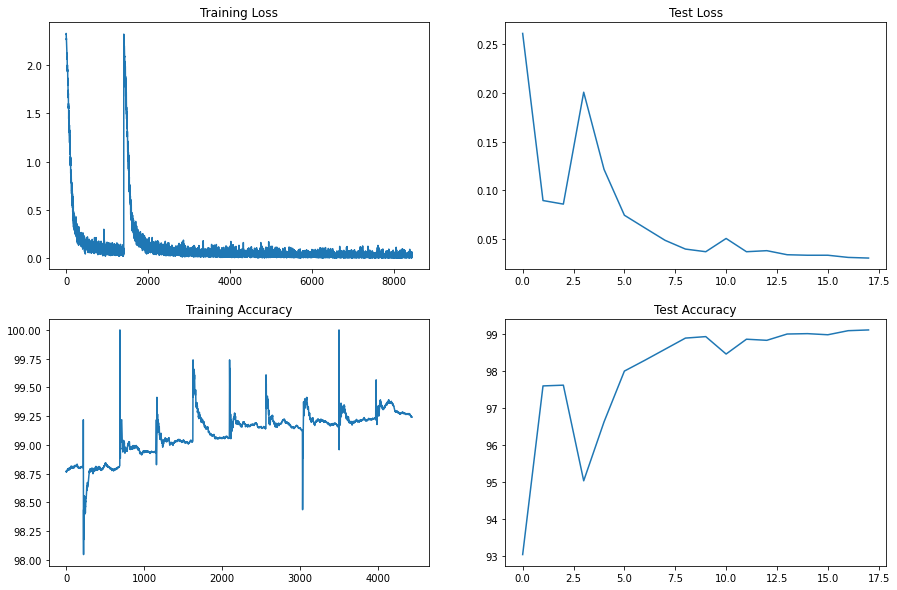

In [99]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")